In [0]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt #for plotting
from collections import Counter
from sklearn.metrics import confusion_matrix
import itertools
import seaborn as sns
from subprocess import check_output
from keras.datasets import mnist
%matplotlib inline

In [0]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

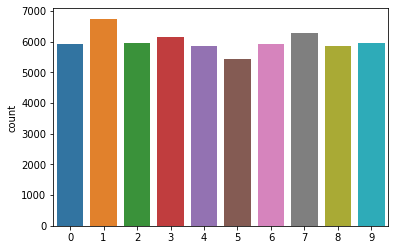

In [18]:
sns.countplot(y_train)

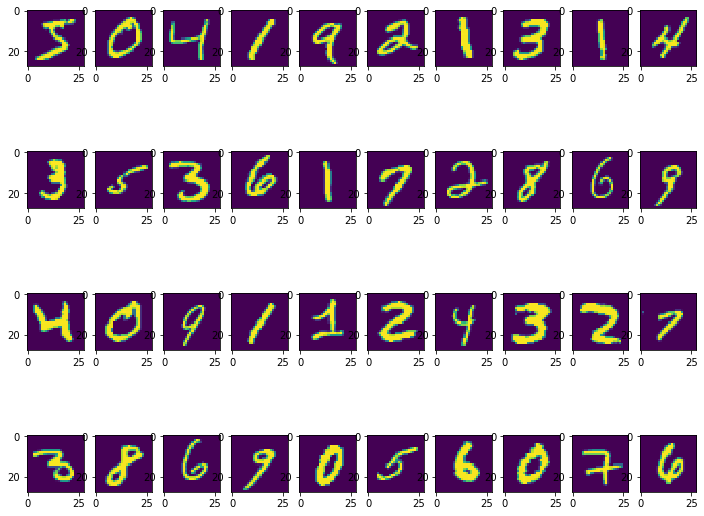

In [19]:
%matplotlib inline
# preview the images first
plt.figure(figsize=(12,10))
x, y = 10, 4
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape((28,28)),interpolation='none')
plt.show()

In [20]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28)
60000 train samples
10000 test samples


In [0]:
X_train = x_train.reshape(x_train.shape[0], 28, 28,1)
X_test = x_test.reshape(x_test.shape[0], 28, 28,1)

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
batch_size = 64
num_classes = 10
epochs = 20
input_shape = (28, 28, 1)


In [0]:
y_train = keras.utils.to_categorical(y_train, num_classes)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

In [0]:
model = Sequential()
# input: 28x28 images with 3 channels -> (28, 28, 1) tensors.
# this applies 32 convolution filters of size 3x3 each.

model.add(Conv2D(64, (3, 3), activation='relu',  padding = 'same', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu',  padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
model.add(Conv2D(128, (3, 3), activation='relu',  padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3), activation='relu',  padding = 'same'))
model.add(Conv2D(256, (3, 3), activation='relu',  padding = 'same'))
model.add(Conv2D(256, (3, 3), activation='relu',  padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu',  padding = 'same'))
model.add(Conv2D(512, (3, 3), activation='relu',  padding = 'same'))
model.add(Conv2D(512, (3, 3), activation='relu',  padding = 'same'))
model.add(MaxPooling2D(pool_size=(1, 1)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(512, (3, 3), activation='relu',  padding = 'same'))
model.add(Conv2D(512, (3, 3), activation='relu',  padding = 'same'))
model.add(Conv2D(512, (3, 3), activation='relu',  padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
dropout_9 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 14, 14, 128)      

In [27]:
datagen.fit(X_train)
h = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction],)

Epoch 1/20
843/843 [==============================] - 108s 128ms/step - loss: 1.2478 - accuracy: 0.6032 - val_loss: 2.1614 - val_accuracy: 0.8710
Epoch 2/20
843/843 [==============================] - 106s 126ms/step - loss: 0.8946 - accuracy: 0.9250 - val_loss: 0.1404 - val_accuracy: 0.9650
Epoch 3/20
843/843 [==============================] - 106s 126ms/step - loss: 0.8275 - accuracy: 0.9331 - val_loss: 13.4950 - val_accuracy: 0.8715
Epoch 4/20
843/843 [==============================] - 106s 126ms/step - loss: 0.4854 - accuracy: 0.9409 - val_loss: 0.1652 - val_accuracy: 0.9800
Epoch 5/20
843/843 [==============================] - 106s 126ms/step - loss: 0.4368 - accuracy: 0.9483 - val_loss: 0.1835 - val_accuracy: 0.9718
Epoch 6/20
843/843 [==============================] - 106s 126ms/step - loss: 0.3324 - accuracy: 0.9521 - val_loss: 0.1894 - val_accuracy: 0.9780
Epoch 7/20
843/843 [==============================] - 106s 126ms/step - loss: 0.8975 - accuracy: 0.9572 - val_loss: 1.1768 

In [28]:
final_loss, final_acc = model.evaluate(X_val, Y_val, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.178657, final accuracy: 0.989833


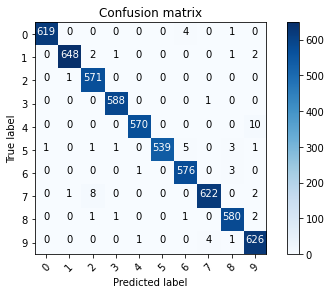

In [30]:
# Look at confusion matrix 
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
import numpy as np
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy', 'lr'])


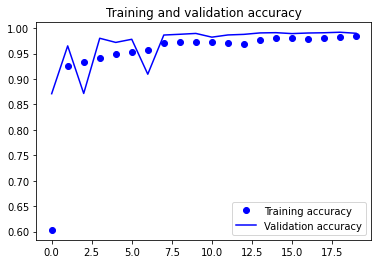

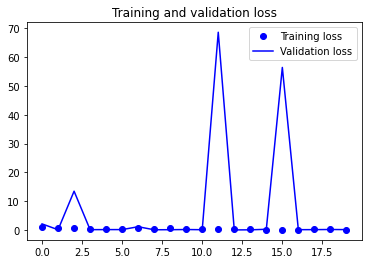

In [31]:
print(h.history.keys())
accuracy = h.history['accuracy']
val_accuracy = h.history['val_accuracy']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

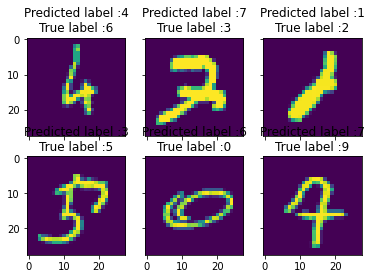

In [32]:
# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

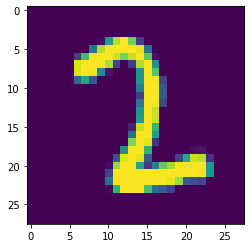

In [33]:
test_im = X_train[154]
plt.imshow(test_im.reshape(28,28), cmap='viridis', interpolation='none')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("co..., outputs=[<tf.Tenso...)`
  This is separate from the ipykernel package so we can avoid doing imports until


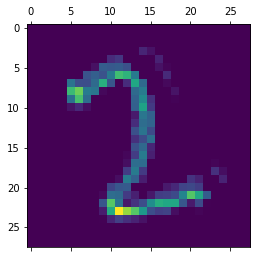

In [34]:
from keras import models
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(input=model.input, output=layer_outputs)
activations = activation_model.predict(test_im.reshape(1,28,28,1))

first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

In [43]:
first_layer_activation.shape

(1, 28, 28, 64)

In [35]:
model.layers[:-1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


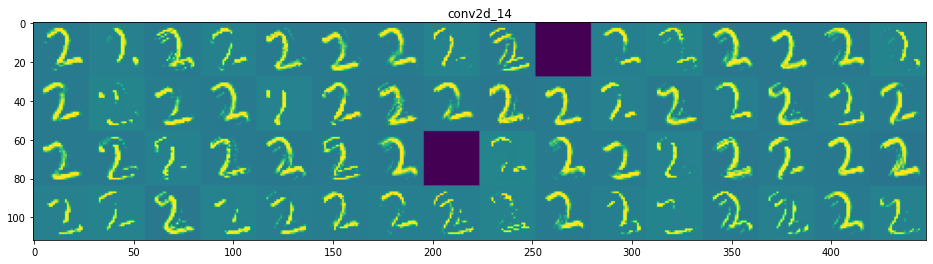

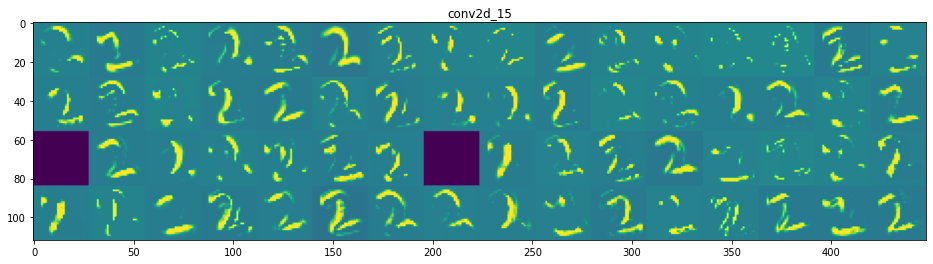

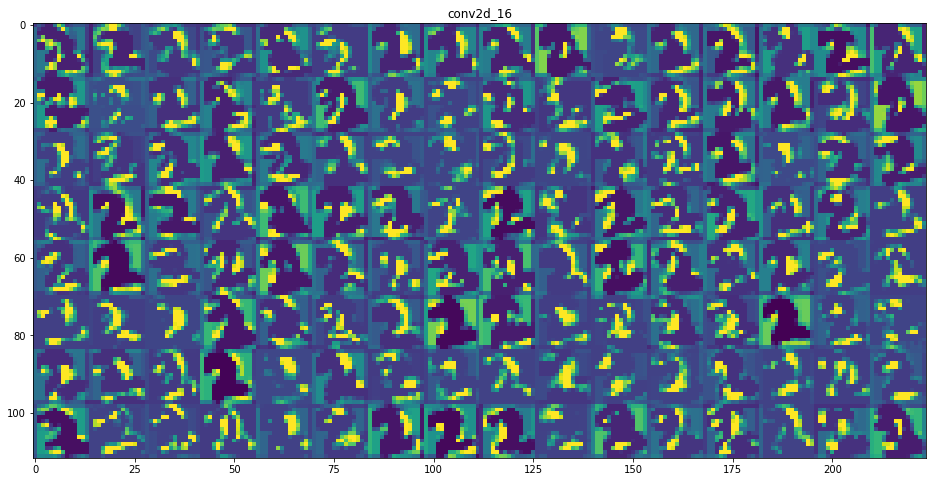

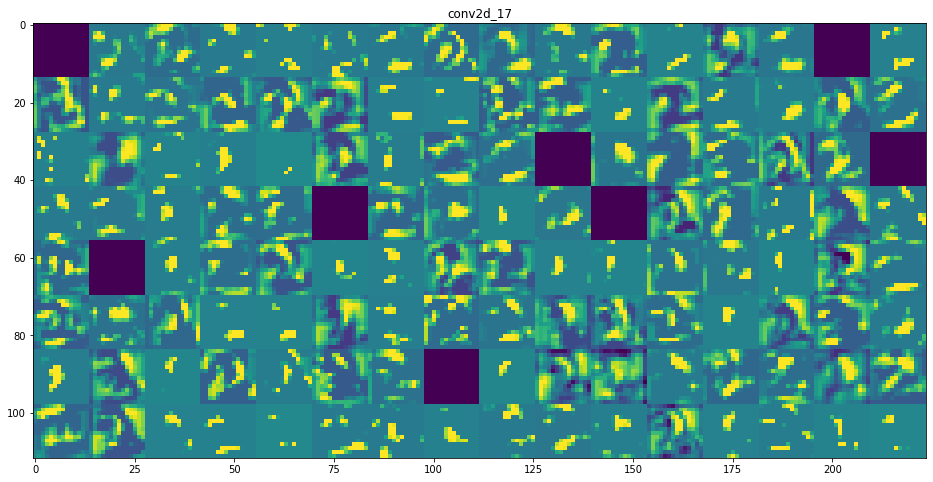

In [36]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('conv'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


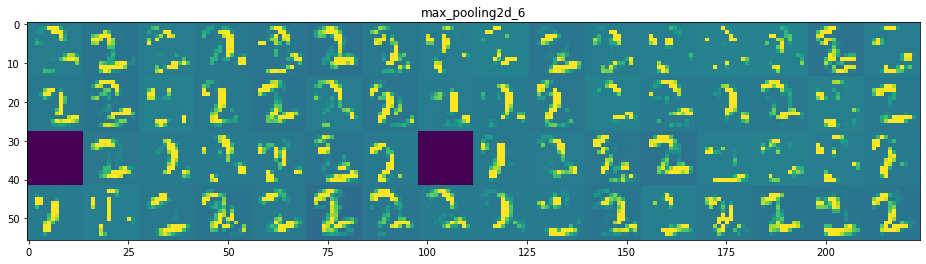

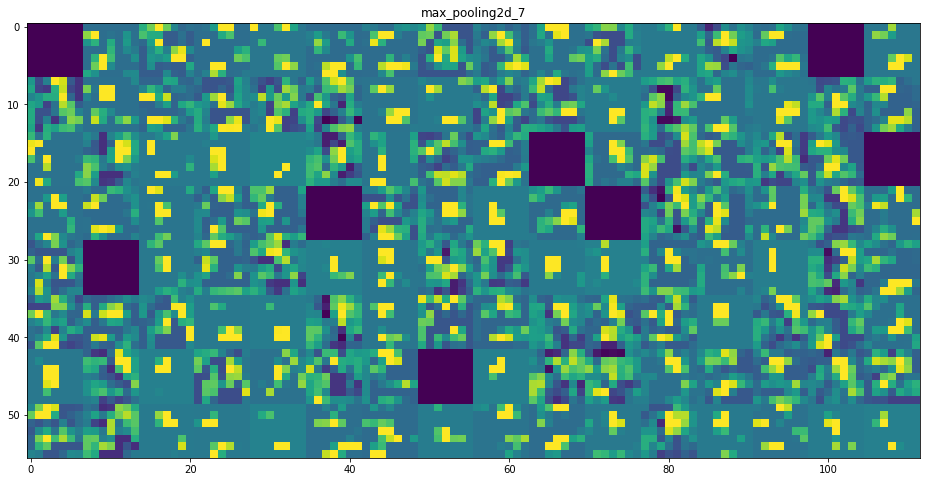

In [37]:

layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('max'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


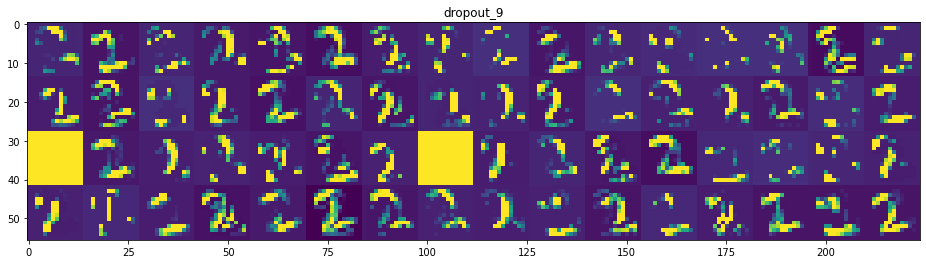

In [38]:
layer_names = []
for layer in model.layers[:-1]:
    layer_names.append(layer.name) 
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    if layer_name.startswith('drop'):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,:, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [0]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true_classes = np.argmax(Y_val, axis = 1)

In [40]:
Y_pred_classes[:5], Y_true_classes[:5]

(array([7, 3, 8, 9, 3]), array([7, 3, 8, 9, 3]))

In [41]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(Y_true_classes, Y_pred_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       1.00      0.99      1.00       624
     Class 1       1.00      0.99      0.99       654
     Class 2       0.98      1.00      0.99       572
     Class 3       0.99      1.00      1.00       589
     Class 4       1.00      0.98      0.99       580
     Class 5       1.00      0.98      0.99       551
     Class 6       0.98      0.99      0.99       580
     Class 7       0.99      0.98      0.99       633
     Class 8       0.98      0.99      0.99       585
     Class 9       0.97      0.99      0.98       632

    accuracy                           0.99      6000
   macro avg       0.99      0.99      0.99      6000
weighted avg       0.99      0.99      0.99      6000

